In [1]:
# Copyright 2018 Esref Ozdemir
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Variable Ranking and Feature Selection
In this document, we will be ranking and analyzing features to see which ones are important in predicting

* null
* goal
* corner
* freekick
* penalty

using a **single decision tree with very limited maximum depth**. We will draw the confusion matrices, feature importances and the decision tree itself to see which feature it uses at each level. This is going to be very useful in determining if the decision trees are learning the events we want them to learn or simply overfitting the data.

In [1]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt

import numpy as np
import scipy as sc
import scipy.linalg as la

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('compute.use_bottleneck', True)
pd.set_option('compute.use_numexpr', True)

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

from collections import Counter

with open('../data/event_names.pkl', 'rb') as f:
    event_names = pickle.load(f)
   
print('Event ids and names')
event_names

Event ids and names


{-931: 'Home Penalty',
 -930: 'Away Penalty',
 -801: 'Home Goal',
 -800: 'Away Goal',
 -621: 'Home Freekick',
 -620: 'Away Freekick',
 -601: 'Home Corner',
 -600: 'Away Corner',
 -21: 'Home Possession',
 -20: 'Away Possession',
 0: 'Null',
 60: 'Corner',
 62: 'Freekick',
 80: 'Goal',
 93: 'Penalty'}

## Training Set

In [2]:
data = pd.read_csv('../data/train/all_train.csv')
data = data.dropna().reset_index(drop=True)
X = data.iloc[:, 1:].values
display(data.tail())

print('ID\tName')
print('--\t----')
for id in np.unique(data['eventId']):
    print('{}\t{}'.format(id, event_names[id]))

,eventId,awayAvgX,awayAvgY,awayConvexCenterX,awayConvexCenterY,awayConvexClosestDistance,awayConvexFarDistance,awayConvexMaxSpeed,awayConvexMaxX,awayConvexMaxY,awayConvexMinX,awayConvexMinY,awayDenseClusterDensity,awayInnerDistance,awaySparseClusterDensity,homeAvgX,homeAvgY,homeConvexCenterX,homeConvexCenterY,homeConvexClosestDistance,homeConvexFarDistance,homeConvexMaxSpeed,homeConvexMaxX,homeConvexMaxY,homeConvexMinX,homeConvexMinY,homeDenseClusterDensity,homeInnerDistance,homeSparseClusterDensity,maxClusterImpurity,playerConvexCenterX,playerConvexCenterY,playerConvexClosestDistance,playerConvexFarDistance,playerConvexMaxSpeed,playerConvexMaxX,playerConvexMaxY,playerConvexMinX,playerConvexMinY,playerDenseClusterDensity,playerSparseClusterDensity,playerVerticalLinearity,refSpeed,refX,refY
12014,93,87.213000,37.402000,86.942000,38.970000,8.698551,32.489624,1.066068,104.46,50.12,54.47,14.21,0.933988,938.916739,0.165928,75.44625,54.31000,72.890000,56.020000,13.150380,22.635443,2.055480,90.42,67.66,60.79,41.70,0.790365,563.044249,0.480858,0.493827,79.797143,47.041429,10.179540,41.062869,2.055480,104.46,67.66,54.47,14.21,0.443863,0.244145,1.870907,1.087796,94.22,39.70
12015,93,85.298889,40.223333,82.678333,39.648333,10.445088,28.865484,1.289729,94.27,50.07,53.84,28.43,1.131180,654.150848,0.166645,75.66000,54.00000,72.906000,55.842000,12.818618,22.104886,1.566684,90.99,67.79,60.52,43.13,0.916873,552.173258,0.429387,0.493827,77.430000,46.306250,13.495459,25.963973,1.566684,94.27,67.79,53.84,28.43,0.747506,0.259059,2.878966,1.590629,94.09,40.78
12016,93,85.406667,40.493333,82.731667,40.241667,10.990523,29.338070,1.410319,94.30,49.47,53.45,28.69,1.325136,655.163752,0.164863,75.66875,53.70000,71.468000,56.096000,11.426825,22.778506,1.572037,90.93,67.62,59.88,44.26,0.993451,543.478110,0.378720,0.493827,77.371250,46.551250,14.104063,25.673679,1.473839,94.30,67.62,53.45,28.69,0.723578,0.280277,2.701213,0.849294,93.59,42.29
12017,93,86.380000,36.735556,86.384000,37.292000,2.767400,11.764888,0.530094,88.08,44.67,83.73,25.65,1.586526,297.219990,0.752229,76.43250,38.16875,76.800000,38.696667,11.329568,15.591985,1.113059,88.65,50.00,63.68,26.61,0.411267,465.129529,0.386518,0.468750,78.658571,39.265714,9.880118,16.557506,1.113059,88.65,50.00,63.68,25.65,1.169960,0.386518,7.271095,1.604307,91.99,42.50
12018,93,30.573750,37.155000,33.766667,37.596667,11.014339,20.273208,2.953726,52.46,48.44,13.53,21.77,0.722588,588.701105,0.243459,20.68125,38.03750,21.108571,39.417143,5.323228,28.845989,3.502228,41.46,59.86,14.71,25.51,0.565057,472.065932,0.000000,0.500000,27.791429,38.275714,11.581852,25.548214,1.240846,52.46,59.86,13.53,21.77,0.852795,0.241942,3.004451,0.871321,1.59,34.95


ID	Name
--	----
0	Null
60	Corner
62	Freekick
80	Goal
93	Penalty


## Decision Tree Variable Ranking
In this section we build decision trees to see which variables are the most important when splitting the dataset according to Gini index. We proceed by performing cross validation on the training dataset. In each fold, a decision tree is trained to maximum depth $d$ from the training part. Then, the test part is predicted using the trained decision tree. In each fold, the resulting confusion matrix, feature importances and decision tree itself are drawn.

In [3]:
from utils import plot_hbar_nameval, plot_confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from IPython.display import Image, display

import pydotplus

def decision_tree_cv(X, y, depth=3, k=10, feature_names=None, class_names=None):
    label_ids = sorted(np.unique(y), key=abs)
    
    clf = tree.DecisionTreeClassifier(
        class_weight='balanced',
        max_depth=depth,
    )
    
    skf = KFold(n_splits=k, shuffle=True)
    skf.get_n_splits(X, y)
    
    cm_list = []
    importance_list = []
    tree_list = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
 
        clf = clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        conf_mat = confusion_matrix(y_test, y_pred, labels=label_ids)
        fig, ax = plot_confusion_matrix(conf_mat, class_names, 'Prediction', 'Truth', normalize=True)
        cm_list.append(fig)
        
        fig, ax = plot_hbar_nameval(feature_names, clf.feature_importances_, 'Feature importances', max_bars=10)
        importance_list.append(fig)
        
        dot_data = tree.export_graphviz(
            clf,
            out_file=None,
            feature_names=feature_names,
            class_names=class_names,
            filled=True,
        )
        graph = pydotplus.graph_from_dot_data(dot_data)
        fig = Image(graph.create_png())
        tree_list.append(fig)
        
    return cm_list, importance_list, tree_list

### Decision Tree Results and Drawing
You can change the depth parameter to change the decision tree depth. Lowering the depth decreases classifier performance as expected. In this example, we use depth 3 to see top 3 most important features drawn as a pydotplus graph. Increasing the depth to 5 actually enables the classifier to distinguish the events somewhat properly.

We can also see that depth 3 decision tree is not able to distinguish the last 3 events from each other. This makes sense since a depth 3 decision tree makes only 3 decisions per path from root to a leaf. If we assume each decision "decides a class", then depth-3 decision tree would find 3 classes. In our case, it does this by dividing the dataset into

* null
* corner
* freekick + goal + penalty

classes.

In [4]:
y = data.values[:, 0]
features = list(data.columns[1:])

events = [0, 60, 62, 80, 93]

mask = np.in1d(y, events)

cm_list_all, importance_list_all, tree_list_all = decision_tree_cv(
    X[mask],
    y[mask],
    depth=3,
    k=10,
    feature_names=features,
    class_names=[event_names[eid] for eid in sorted(events)]
)

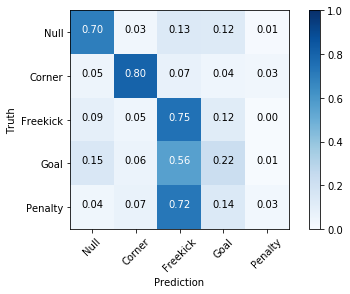

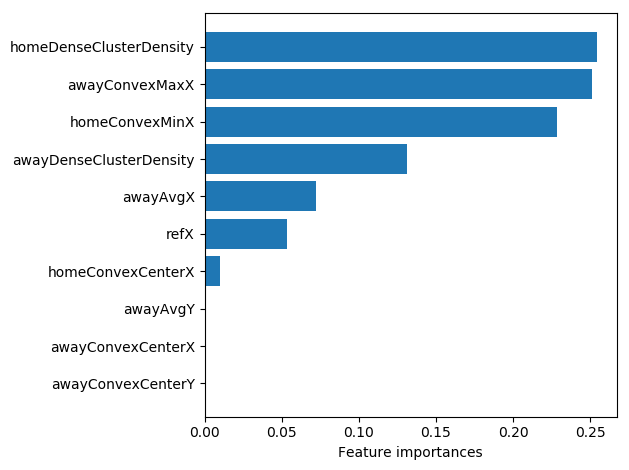

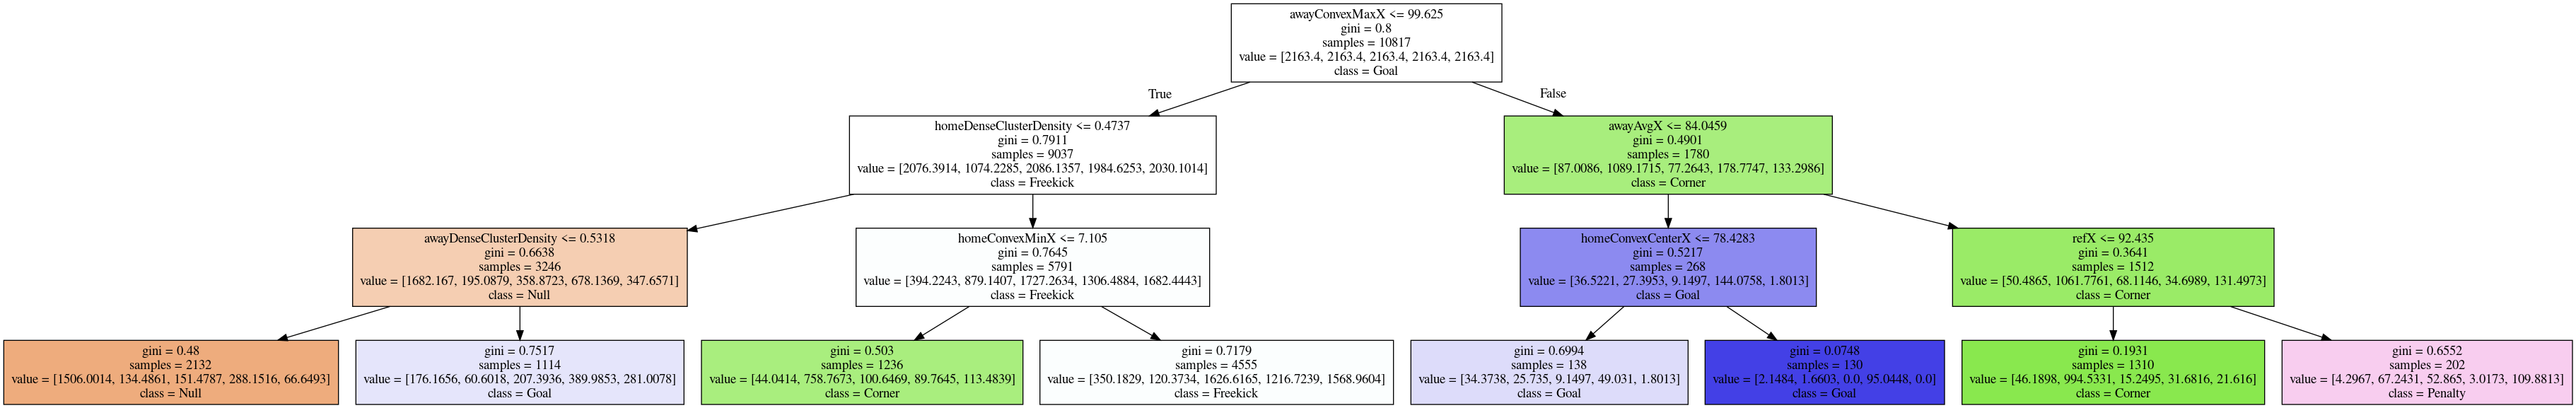

In [5]:
index = 0
display(cm_list_all[index])
display(importance_list_all[index])
display(tree_list_all[index])

You can double click the tree above to zoom in.

### Predicting Individual Events
In most cases, decision tree perform poorly in predicting the specified events. This may be due to
1. **Very high class imbalance:** Since we collapse all other events apart from the one we are interested into a single class, we obtain a highly imbalanced training set. The algorithms obtain very high accuracy due to simply choosing the majority class, while in fact performing very poorly on the interesting cases.
2. **Noisy labelling:** Since we have used a fixed amount of time intervals while labelling samples instead of manually checking to which event class a given frame belongs to, classifier may have difficulties in learning the representation of a given class.
3. **Maximum depth:** The trees are grown to depth 3 only.

#### Penalty
Penalty prediction is problematic due to very few samples.

Penalty class has few samples, but it is a very distinctive class. We might try the following to increase classifier performance for penalty events:

1. Increase number of penalty samples by getting more frames for penalty events. (Increasing event interval in training set construction).
  * How healthy is this?
2. Use features that can distinguish penalty events. Examples are
  * A way of measuring degree of local linearity. Defending players form a linear shape
    just before a penalty kick.
  * A way of measuring degree of tight clustering.
3. Use oversampling methods to increase penalty samples.
  * SMOTE may be useful.

## Predicting Null Event vs Penalty
In this section, we run the decision tree to do binary classification between the null event and penalty. Even a depth 2 decision tree achieves great performance while yielding interpretable results:

* The fact that homeClusterDensity and refX are the most important features is in line with our football common sense. This also increases our confidence that our traning set is good.

In [6]:
y = data['eventId'].values
mask = (y == 93) | (y == 0)
events = [0, 93]

cm_list_pen, importance_list_pen, tree_list_pen = decision_tree_cv(
    X[mask],
    y[mask],
    depth=2,
    k=10,
    feature_names=features,
    class_names=[event_names[eid] for eid in sorted(events)]
)

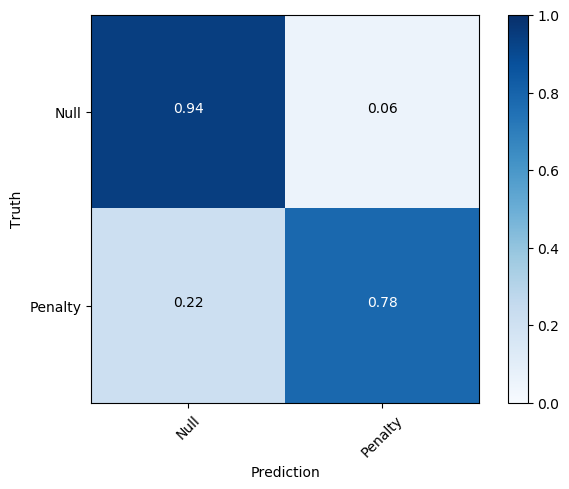

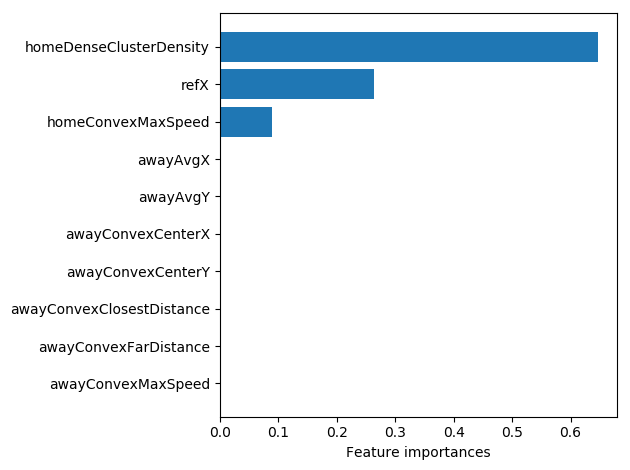

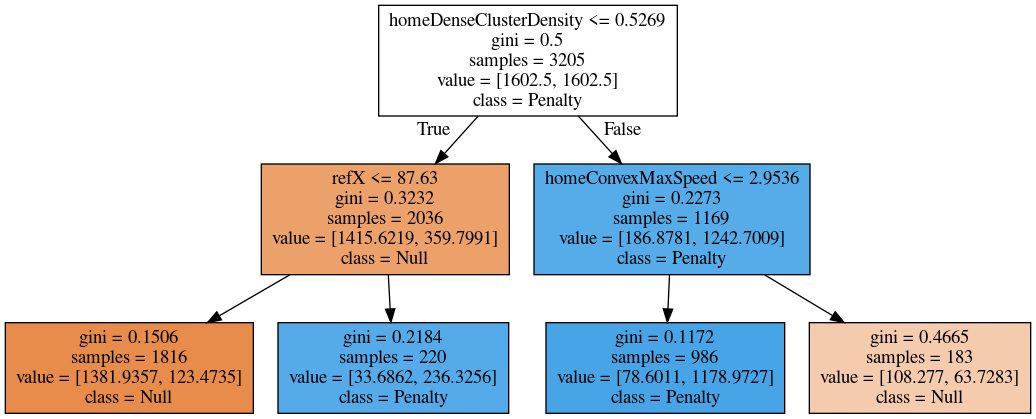

In [7]:
index = 8
display(cm_list_pen[index])
display(importance_list_pen[index])
display(tree_list_pen[index])

## Predicting Corner vs Null
In this section, we perform binary classification between corner and null event. We note that the the learned features in this case are different. Importance of inner distance and maximum X features make sense since during a corner, most of the players have either very high or very low x coordinates and the inner distance is generally very low.

In [8]:
y = data['eventId'].values
mask = (y == 0) | (y == 60)
events = [0, 60]

cm_list_corner, importance_list_corner, tree_list_corner = decision_tree_cv(
    X[mask],
    y[mask],
    depth=2,
    k=10,
    feature_names=features,
    class_names=[event_names[eid] for eid in sorted(events)]
)

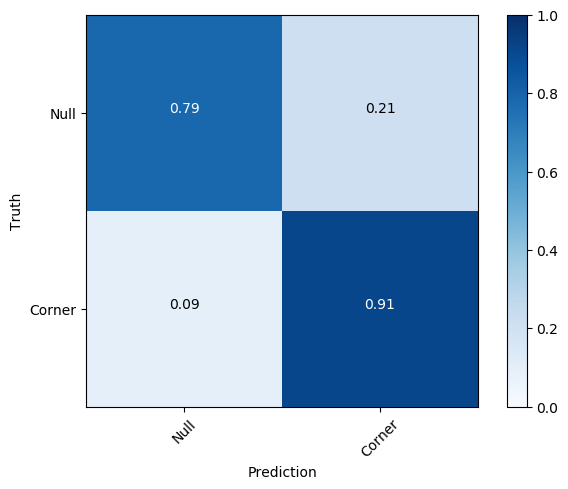

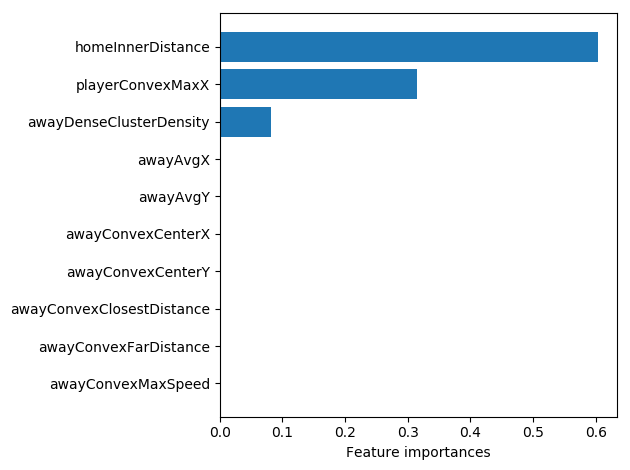

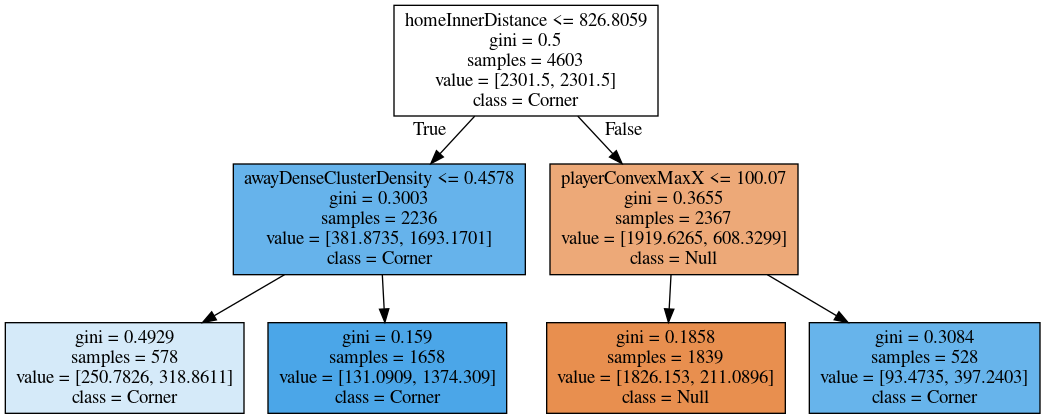

In [9]:
index = 5
display(cm_list_corner[index])
display(importance_list_corner[index])
display(tree_list_corner[index])